In [1]:
import pandas as pd
import USA_oil_data as oil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

In [2]:
weekly_stocks = oil.weekly_stocks().to_frame()
weekly_stocks['change'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks['SD_change'] = weekly_stocks['change'].diff(-52)

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']
weekly_stocks = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

weekly_stocks = weekly_stocks[weekly_stocks['week'] <= 52]
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

grouped = weekly_stocks.groupby('year')

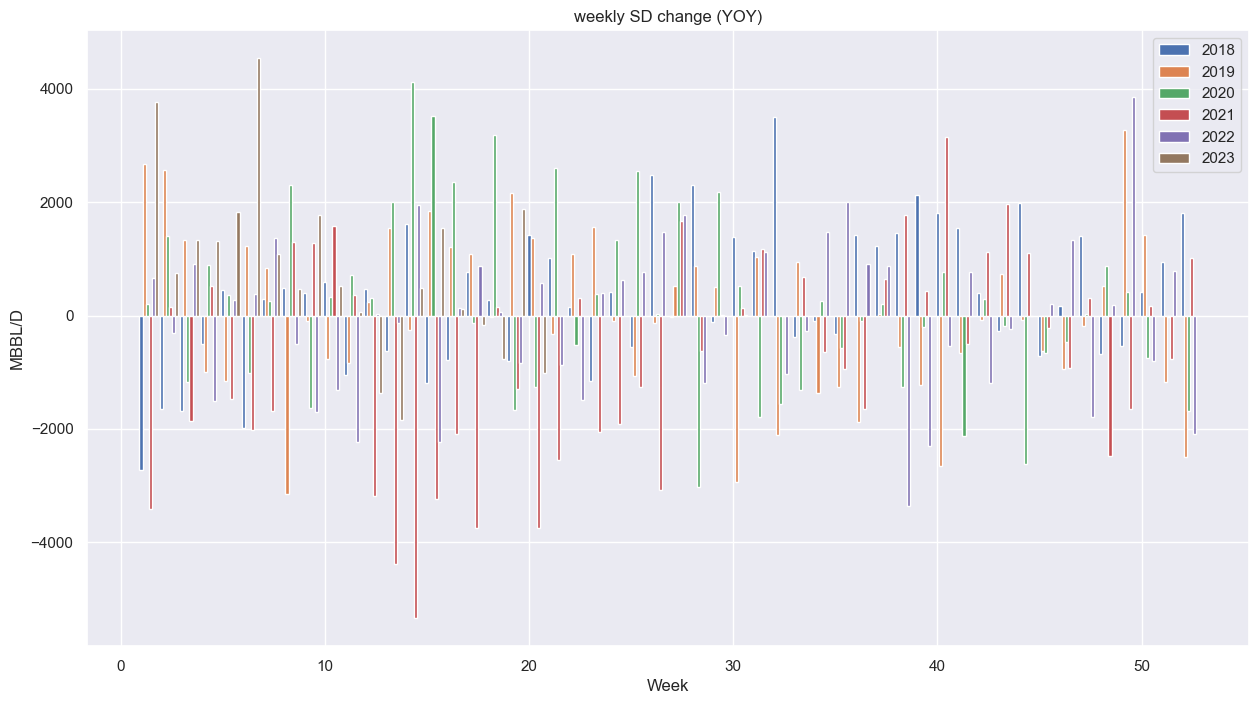

In [3]:
pos = 0
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['week']
    data = group['SD_change'] / 7
    data = data[:52]
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1
plt.legend()
plt.xlabel('Week')
plt.ylabel('MBBL/D')
plt.title('weekly SD change (YOY)')
plt.show()

In [4]:
monthly_SD_data = []
for name, group in grouped:
    year = name
    monthly_group = group.groupby('month')
    for n, g in monthly_group:
        week = n
        data = g['SD_change'].sum() / 7
        monthly_SD_data.append([year, week, data])

monthly_SD_df = pd.DataFrame(monthly_SD_data, columns=['year', 'month', 'SD_change'])

grouped = monthly_SD_df.groupby('year')

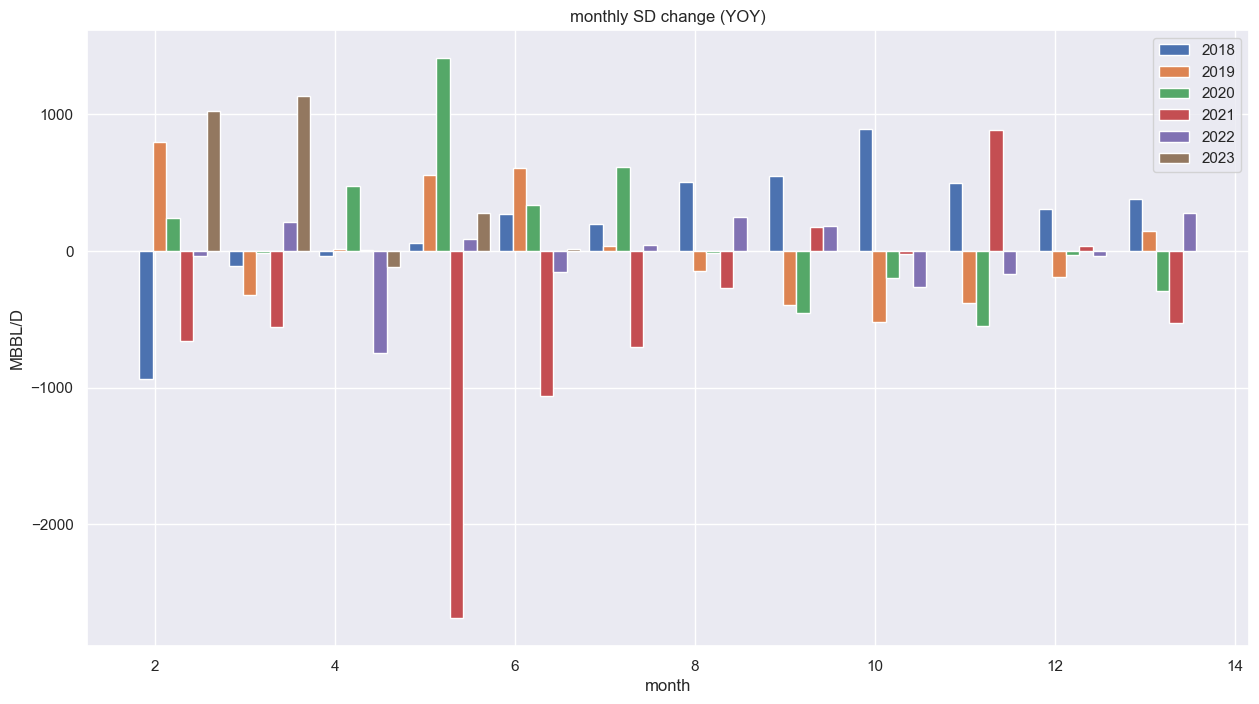

In [5]:
os = 0
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['month']
    data = group['SD_change'] / 7
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1

plt.legend()
plt.xlabel('month')
plt.ylabel('MBBL/D')
plt.title('monthly SD change (YOY)')
plt.show()

In [6]:
monthly_SD_df['date'] = pd.to_datetime(monthly_SD_df['year'].astype(str) + '-' + monthly_SD_df['month'].astype(str) + '-1')

In [7]:
monthly_SD_df.set_index('date', inplace=True)

In [8]:
display(monthly_SD_df)

,year,month,SD_change
date,,,
2018-01-01,2018,1,-6575.285714
2018-02-01,2018,2,-763.714286
2018-03-01,2018,3,-239.857143
2018-04-01,2018,4,394.285714
2018-05-01,2018,5,1902.714286
...,...,...,...
2023-01-01,2023,1,7169.428571
2023-02-01,2023,2,7926.142857
2023-03-01,2023,3,-836.285714


In [9]:
#net imports
imports, exports = oil.imports_exports(only_crude=False)
imports_exports = pd.merge(imports, exports, on='period')
imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]
net_imports = imports_exports['imports'] - imports_exports['exports']
net_imports.rename("net_imports", inplace=True)
net_imports = net_imports.groupby(pd.Grouper(freq='MS')).mean()

#production
production = oil.mbbl_production(daily=True)

#product supplied (EIA uses product supplied to represent U.S. petroleum consumption)
product_supplied = oil.monthly_product_supplied()
product_supplied = product_supplied * -1

#refinery/blender net inputs
net_refinery = oil.refinery_net_input(daily=True)

supply_demand = pd.merge(production, product_supplied, on='period')
supply_demand = pd.merge(supply_demand, net_imports, on='period')
#supply_demand = pd.merge(supply_demand, net_refinery, on='period')

changes = supply_demand.diff(12)

sd = monthly_SD_df['SD_change'].rename('SD')



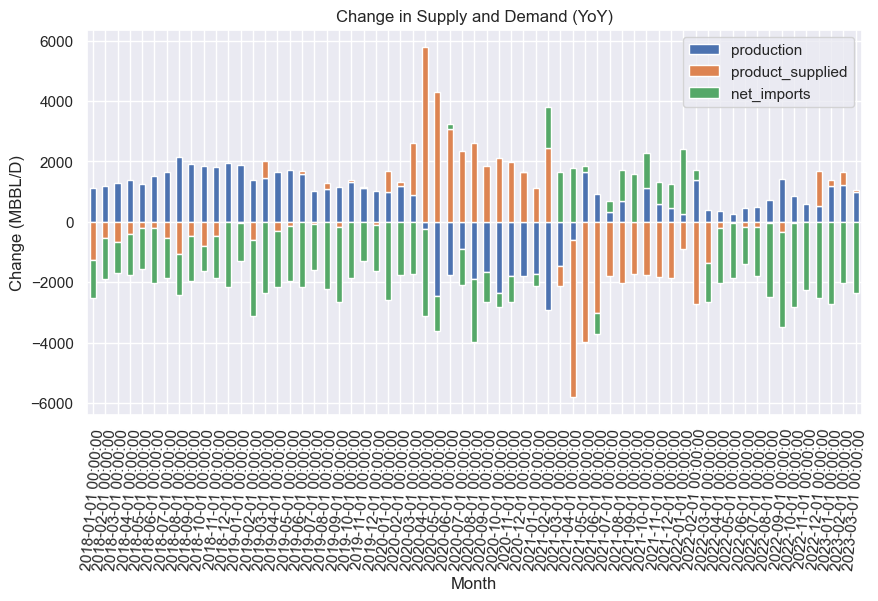

In [10]:
changes = changes[changes.index > '2017-12-01']
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
plt.title('Change in Supply and Demand (YoY)')
ax.set_xlabel('Month')
ax.set_ylabel('Change (MBBL/D)')
plt.xticks(rotation=85)
plt.show()

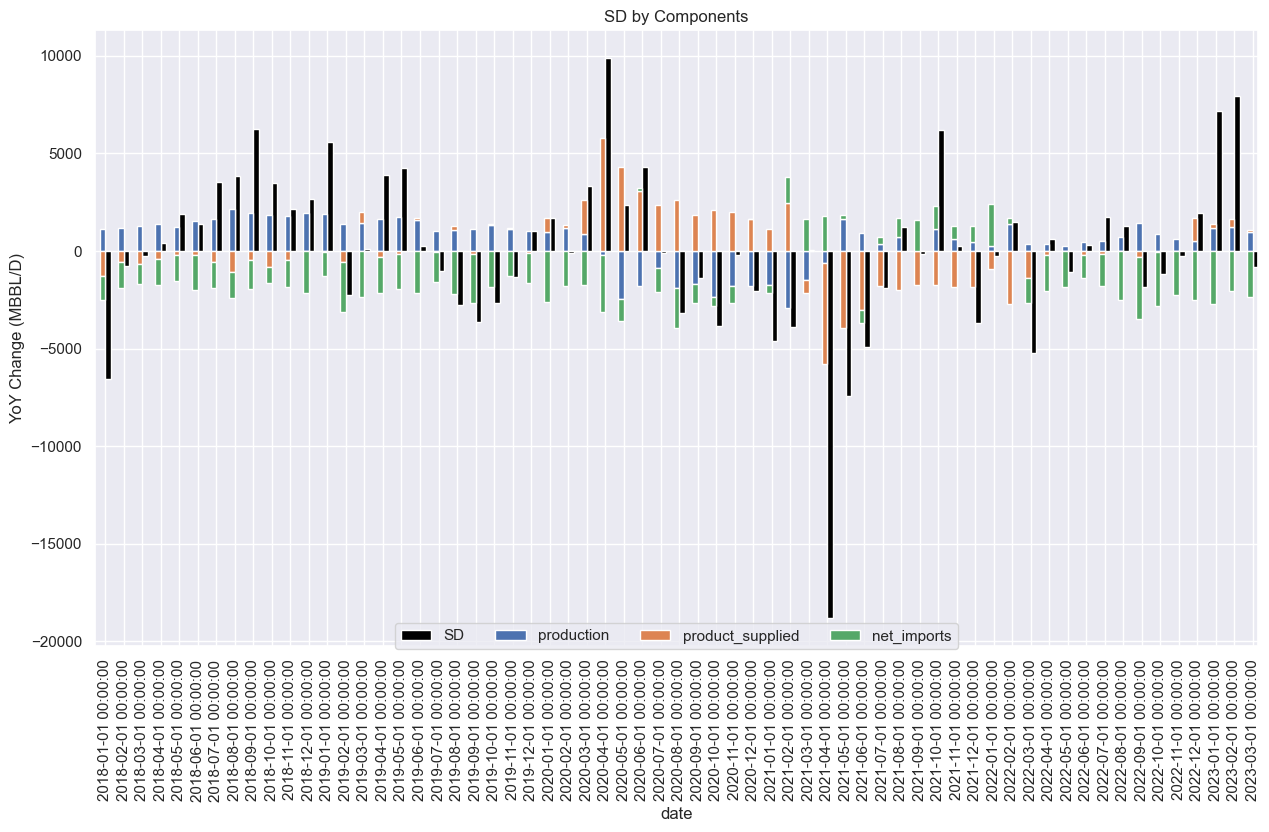

In [11]:
sd_data = sd[sd.index > '2017-12-01' ]
ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)


plt.title('SD by Components')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.ylabel('YoY Change (MBBL/D)')
plt.xlabel('date')
plt.show()

# testing

In [104]:
stocks = oil.weekly_stocks().to_frame()
stocks['change'] = stocks['stocks'].diff(-1)
stocks['SD_change'] = stocks['change'].diff(-52)

In [105]:
product_supplied = oil.weekly_product_supplied()

In [106]:
imports, exports = oil.imports_exports(only_crude=False)
net_imports = imports - exports
net_imports = net_imports.rename("net_imports")

In [107]:
refinery_inputs = oil.weekly_refinery_inputs()

In [108]:
master_df = pd.merge(product_supplied, net_imports, on='period')
master_df = pd.merge(master_df, refinery_inputs, on='period')


In [109]:
changes = master_df.diff(52)

In [110]:
stocks['SD_change'] = stocks['SD_change']

In [111]:
sd_data = stocks['SD_change'].rename('SD')

In [112]:
start_date = '2021-12-01'
changes = changes[changes.index > start_date]
sd_data = sd_data[sd_data.index > start_date]

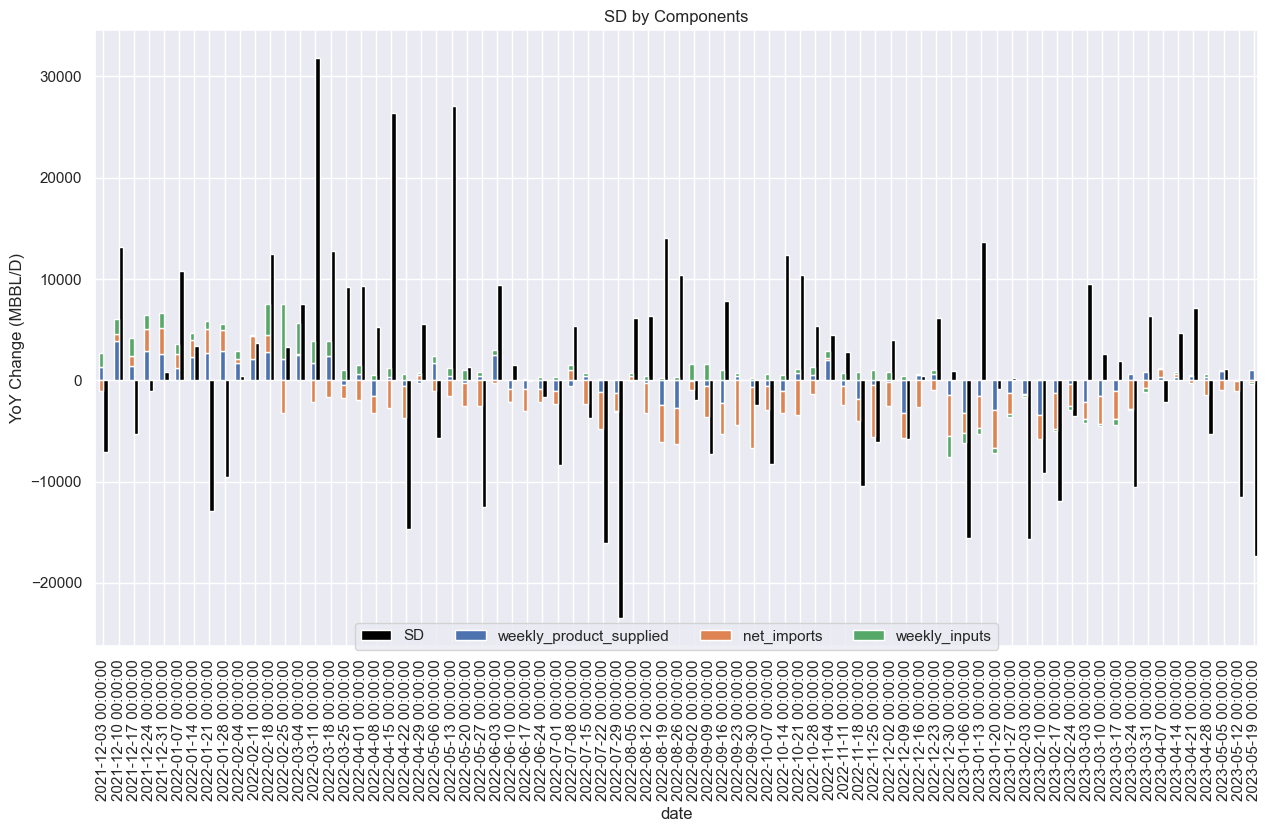

In [113]:
ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)


plt.title('SD by Components')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.ylabel('YoY Change (MBBL/D)')
plt.xlabel('date')
plt.show()

<Axes: xlabel='Date', ylabel='MBBL'>

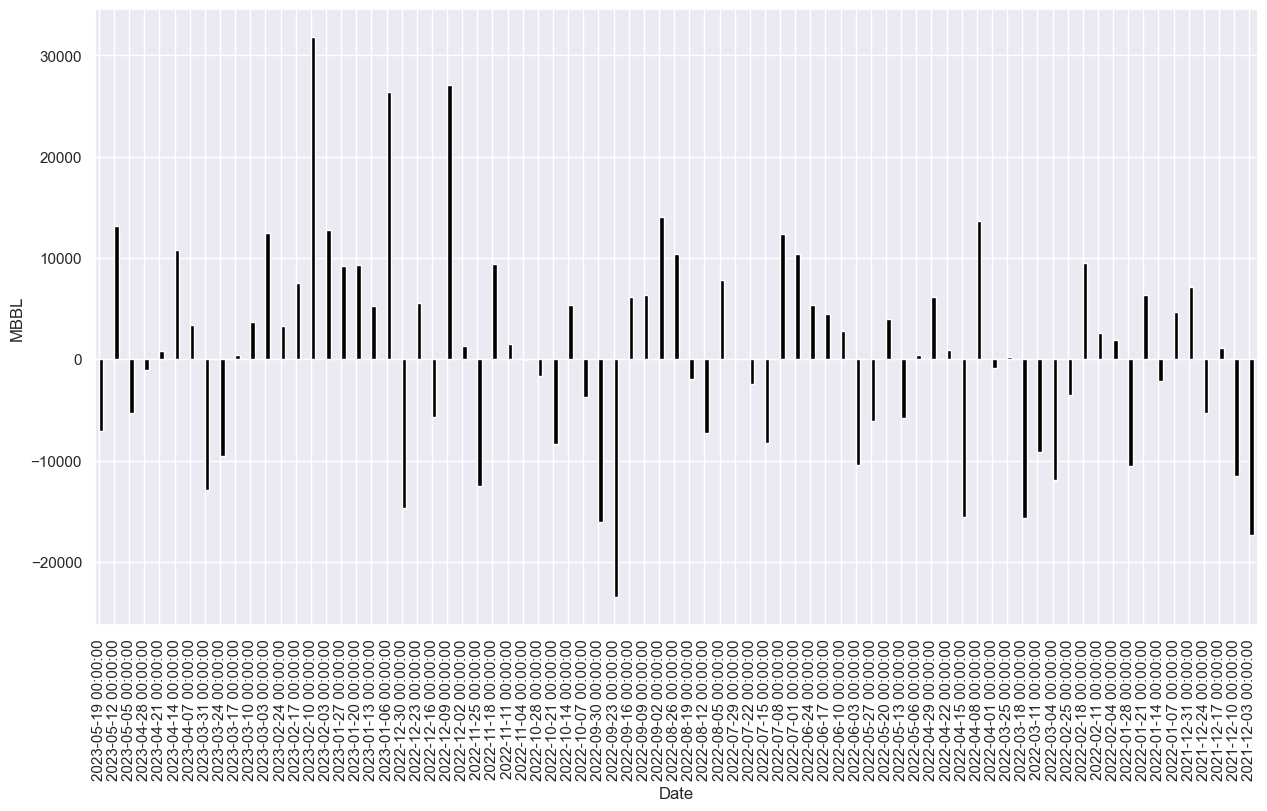

In [78]:
sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

In [79]:
stocks

,stocks,change,SD_change
period,,,
2023-05-19,1589539,-12399.0,-7084.0
2023-05-12,1601938,5185.0,13124.0
2023-05-05,1596753,-2441.0,-5339.0
2023-04-28,1599194,-1587.0,-1108.0
2023-04-21,1600781,-1414.0,773.0
...,...,...,...
1990-02-02,1631318,18393.0,NaN
1990-01-26,1612925,12851.0,NaN
1990-01-19,1600074,6656.0,NaN


In [80]:
sd_data

period
2023-05-19    -7084.0
2023-05-12    13124.0
2023-05-05    -5339.0
2023-04-28    -1108.0
2023-04-21      773.0
               ...   
2021-12-31     7164.0
2021-12-24    -5338.0
2021-12-17     1150.0
2021-12-10   -11574.0
2021-12-03   -17310.0
Name: SD, Length: 77, dtype: float64